# TP1 : Dynamic Programming and Reinforcement Learning

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

**Discrete MDP model.**

In [284]:
reward=[[0,0,5/100],[0,0,0],[0,1,9/10]]
transition= np.array([[[0.55,0.45,0],[0.3,0.7,0],[1,0,0]],
             [[1,0,0],[0,0.4,0.6],[0,1,0]],
             [[0,1,0],[0,0.6,0.4],[0,0,1]]])
gamma=0.95


**Implement and run value iteration (VI) in order to identify a 0.01–optimal policy.**

In [285]:
def value_iteration():
    value=np.random.uniform(0,1,3)
    value_next=reward+gamma*np.sum(transition*value,axis=2)
    policy=np.argmax(value_next,axis=1)
    values=[value,value_next]
    
    while(np.linalg.norm(value-value_next,ord=np.inf)>0.01):  
        value=value_next
        value_next=np.max(reward+gamma*np.sum(transition*value,axis=2),axis=1)
        policy=np.argmax(reward+gamma*np.sum(transition*value,axis=2),axis=1)
        values.append(value_next)
        
    return(policy,values)


In [286]:
p0,values_0=value_iteration()

Text(0,0.5,'$||v^{k+1}-v^{k}||$')

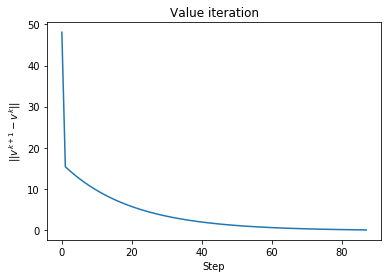

In [294]:
values=[]
for i in range(1,len(values_0)): 
    values.append(np.linalg.norm(values_0[i]-values_0[-1],ord=np.inf))
plt.plot(values)
plt.title('Value iteration')
plt.xlabel('Step')
plt.ylabel('$||v^{k+1}-v^{k}||$')

**implement exact policy iteration (PI) with initial policy π0 = [a0, a0, a0].**

In [288]:
def policy_iteration():
    policy=np.array(random.sample([0,1,2],3))
    value=np.random.uniform(0,1,3)
    P=np.array([transition[l, i, :] for l, i in enumerate(policy)])
    value_next=np.linalg.inv(np.identity(3)-gamma*P)*reward
    values=[value,value_next]
    policy_next=np.argmax(reward+gamma*np.sum(transition*value,axis=2),axis=1)
    
    while(np.linalg.norm(value-value_next,ord=np.inf)>0.01):
        value=value_next
        policy=policy_next
        P=np.array([transition[l, i, :] for l, i in enumerate(policy)])
        value_next=np.linalg.inv(np.identity(3)-gamma*P)*reward
        values.append(value_next)
        policy_next=np.argmax(reward+gamma*np.sum(transition*value,axis=2),axis=1)
        
    return(policy_next,values)

In [289]:
p1,values_1=policy_iteration()

Text(0,0.5,'$||v^{k+1}-v^{k}||$')

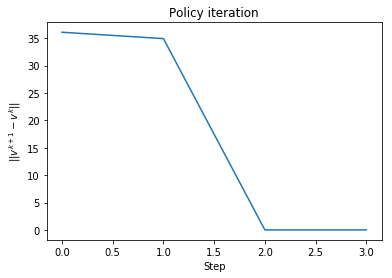

In [295]:
values_policy=[]
for i in range(1,len(values_1)): 
    values_policy.append(np.linalg.norm(values_1[i]-values_1[-1],ord=np.inf))
plt.plot(values_policy)
plt.title('Policy iteration')
plt.xlabel('Step')
plt.ylabel('$||v^{k+1}-v^{k}||$')

**Question :Compare the speed of convergence w.r.t. VI and discuss the relative merits of the two approaches.**


 The convergence of policy iteration is much faster than value iteration. It is computationally cheap w.r.t VI. 
 
 
 Value iteration is simpler but computationnally heavy with $O(S^{2A})$ per iteration (where S is in the number of states and A the number of actions). 

**A Review of RL Agent/Environment Interaction**

In [317]:
from gridworld import GridWorld1
import gridrender as gui
import numpy as np
import time

In [169]:
env = GridWorld1
state1=[]
for i in range(1000):
    state1.append(env.reset())
mu=np.bincount(state1)

In [174]:

pol = [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3]
n=10000
gamma=0.95
count=0
T_max=1/(1-gamma)
R_hat=np.zeros(n)
V=[[] for k in range(11)]
J=np.zeros(n)
for i in range(n):
    term=False
    count=0
    c=env.reset()
    state = c
    rewards=[]
    
    while not term and count<T_max :
            count=count+1
            action = pol[state]
            nexts, reward, term = env.step(state,action)
            rewards.append(reward)
            state = nexts
            
    V[c].append(gamma**(len(rewards))*rewards[-1])
    
    v=[0 for k in range(11)]
    for k in range(11):
        if len(V[k])!=0:
            v[k]=np.sum(V[k])/len(V[k])
    J[i]=np.sum(v*mu)
    
    rewards=[]
    actions=[]
    states=[]
    c=env.reset()
    state=c


v_q4 = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 0.00000000, -0.82847001, -0.87691855,
        -0.93358351, -0.99447514]

**Policy evaluation.**

Text(0,0.5,'$||J_{n}-J^{\\pi}||$')

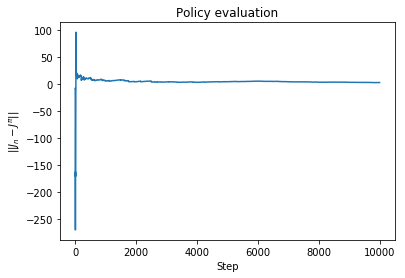

In [296]:
plt.plot(J-np.sum(v_q4*mu))
plt.title('Policy evaluation')
plt.xlabel('Step')
plt.ylabel('$||J_{n}-J^{\pi}||$')

**Policy optimization: the Q-learning algorithm.**

In [318]:
env = GridWorld1

def eps_greedy_policy(eps,Q,state,actions):
    action=actions[np.argmax(Q[state,actions])]
    if np.random.binomial(1,eps)==1 and  actions != [action]:
        action = np.random.choice(list(set(actions) - set([action])))
    return action
def Q_learning_algorithm():
    n=10000
    gamma=0.95
    T_max=1/(1-gamma)
    Qs=[]
    Q=np.zeros((env.n_states, len(env.action_names)))
    visit=np.zeros((env.n_states, len(env.action_names)))
    for i in range(n):
        Q=Q.copy()
        visit=visit.copy()
        t=0
        term=False
        state=env.reset()
        
        while not term and t<T_max :
            
            action=eps_greedy_policy(0.5,Q,state,env.state_actions[state])
            visit[state,action]=visit[state,action]+1
            nexts, reward, term=env.step(state,action)
            alpha=(1/visit[state,action])
            Q[state,action]=((1-alpha)*Q[state,action] + alpha*(reward + gamma*np.max(Q[nexts])))
            state=nexts
            t+=1
        Qs.append(Q)
        
    return(Qs)

In [319]:
Qs=Q_learning_algorithm()
from utils import *
V=[]
for i in range(len(Qs)):
        d=np.argmax
        V.append(v_from_q(11,env.state_actions, np.argmax(Qs[i],axis=1), Qs[i]))
v_star =[0.877,0.928,0.988,0,0.824,0.928,0,0.778,0.824,0.877,0.828]
values=[]
for i in range(1,len(V)): 
    values.append(np.linalg.norm(V[i]-v_star,ord=np.inf))

Text(0.5,0,'Episode')

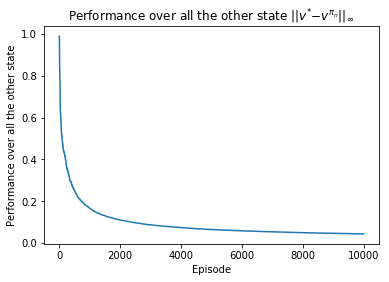

In [306]:
plt.plot(values)
plt.title('Performance over all the other state $||v^{*} − v^{\pi_{n}} || _{\infty}$')
plt.ylabel("Performance over all the other state")
plt.xlabel("Episode")

In [278]:
def cum_rewards(Q, env, gamma=0.95, t_max=1000):
    n=100
    gamma=0.95
    T_max=1/(1-gamma)
    cumulated_rewards = []
    for i in range(n):
        t = 0
        term = False
        rewards = []
        state = env.reset()
        while not term and t < T_max:
            actions = env.state_actions[state]
            action = actions[np.argmax(Q[state, actions])]
            state, reward, term = env.step(state, action)
            rewards.append(reward)
            t += 1
        cumulated_rewards.append(gamma**(t-1)*rewards[-1] )
    return np.linalg.norm(cumulated_rewards)
   
rewards = np.zeros(len(Qs))
for i in range(len(Qs)):
    rewards[i] = cum_rewards(Qs[i], env)

Text(0.5,0,'Episode')

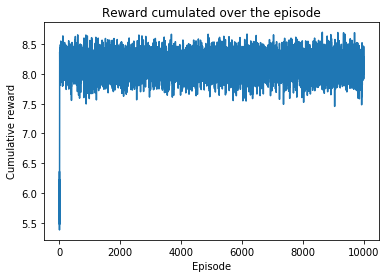

In [298]:
plt.plot(rewards)
plt.title('Reward cumulated over the episode')
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")

**Is the optimal policy of an MDP affected by the change of the initial distribution μ0?**

The optimal policy of an MDP is affected by the change of $\mu_{0}$ if we are in a constrained MDP which is not the case here.  

(Answer based on an article Finite-Horizon Markov Decision Processes with State Constraints
Mahmoud El Chamie and Behc : https://arxiv.org/pdf/1507.01585.pdf)